In [57]:
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Read in CSV Signal Data

In [58]:
csv_path = Path('trading_signals.csv')
df = pd.read_csv(csv_path, parse_dates=['time'], infer_datetime_format=True)

### Set index, time and drop cols

In [59]:
df.set_index(pd.to_datetime(df['time'], infer_datetime_format=True), inplace=True)
df.drop(columns=['time','Unnamed: 0'], inplace=True)

### Set X-Vars and Filter to Obtain Associated Vals

In [60]:
x_var_list = ['macd_crossover_signal', 'rsi', 'rsi_signal', 'crossover_signal','bollinger_signal']
df[x_var_list].head()

,macd_crossover_signal,rsi,rsi_signal,crossover_signal,bollinger_signal
time,,,,,
2017-03-21,0.0,0.0,0.0,0.0,0.0
2017-03-22,1.0,0.0,0.0,1.0,0.0
2017-03-23,1.0,0.0,0.0,1.0,0.0
2017-03-24,1.0,0.0,0.0,-1.0,0.0
2017-03-27,-1.0,0.0,0.0,-1.0,0.0


In [61]:
#shift df index by 1
#this results in yesterdays signals dictating what our positions are today
df[x_var_list] = df[x_var_list].shift(1)
df[x_var_list].tail(10)

,macd_crossover_signal,rsi,rsi_signal,crossover_signal,bollinger_signal
time,,,,,
2021-02-25,-1.0,61.769056,1.0,1.0,0.0
2021-02-26,-1.0,46.155729,1.0,-1.0,0.0
2021-03-01,-1.0,43.537523,1.0,-1.0,0.0
2021-03-02,-1.0,55.594032,1.0,-1.0,0.0
2021-03-03,-1.0,51.752156,1.0,-1.0,0.0
2021-03-04,-1.0,45.887913,1.0,-1.0,0.0
2021-03-05,-1.0,41.231330,1.0,-1.0,1.0
2021-03-08,-1.0,49.291321,1.0,-1.0,0.0
2021-03-09,-1.0,47.399624,1.0,-1.0,0.0


### Drop NAs and Replace Pos/Neg Infiity

In [62]:
df.dropna(subset=x_var_list, inplace=True)
df.dropna(subset=['daily_return'], inplace=True)
df = df.replace([np.inf, -np.inf], np.nan)

In [63]:
#if daily returns are greater than zero then set binary feature of Positive Returns to True
df['Positive Return'] = np.where(df['daily_return'] > 0, 1.0, 0.0)
df[['daily_return','Positive Return']].head()

,daily_return,Positive Return
time,,
2017-03-22,0.002096,1.0
2017-03-23,-0.001110,0.0
2017-03-24,-0.000470,0.0
2017-03-27,-0.001368,0.0
2017-03-28,0.007235,1.0


### Assign Training and Testing Windows

In [64]:
#train on 70%
split = int(0.70 * len(df))
X_train = df[x_var_list][:split]
X_test = df[x_var_list][split:]
y_train = df['Positive Return'][: split]
y_test = df['Positive Return'][split:]
print(f"There are {len(X_train)} records in the Training Set")

There are 699 records in the Training Set


In [65]:
print(f"There are {len(X_test)} records in the Testing Set")

There are 300 records in the Testing Set


### Separate X and y Training sets

In [66]:
X_train.tail()

,macd_crossover_signal,rsi,rsi_signal,crossover_signal,bollinger_signal
time,,,,,
2019-12-23,1.0,74.412641,-1.0,1.0,0.0
2019-12-24,1.0,74.894822,-1.0,1.0,0.0
2019-12-26,1.0,74.970075,-1.0,1.0,0.0
2019-12-27,1.0,77.911374,-1.0,1.0,0.0
2019-12-30,1.0,77.613736,-1.0,1.0,0.0


In [67]:
y_train.tail()

time
2019-12-23    1.0
2019-12-24    1.0
2019-12-26    1.0
2019-12-27    0.0
2019-12-30    0.0
Name: Positive Return, dtype: float64

In [68]:
X_test.tail()

,macd_crossover_signal,rsi,rsi_signal,crossover_signal,bollinger_signal
time,,,,,
2021-03-04,-1.0,45.887913,1.0,-1.0,0.0
2021-03-05,-1.0,41.231330,1.0,-1.0,1.0
2021-03-08,-1.0,49.291321,1.0,-1.0,0.0
2021-03-09,-1.0,47.399624,1.0,-1.0,0.0
2021-03-10,-1.0,53.020507,1.0,-1.0,0.0


In [69]:
y_test.tail()

time
2021-03-04    0.0
2021-03-05    1.0
2021-03-08    0.0
2021-03-09    1.0
2021-03-10    1.0
Name: Positive Return, dtype: float64

### Setup Neural Networks

In [70]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [71]:
tf.random.set_seed(126)

In [72]:
X_scaler = StandardScaler()

In [73]:
#fit the scaler
X_scaler.fit(X_train)

StandardScaler()

In [74]:
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [75]:
X_train.shape

(699, 5)

In [76]:
#define the model
number_inputs = len(x_var_list)
#https://www.vcalc.com/wiki/vCalc/Nodes+in+a+Hidden+Layer
number_hidden_nodes = 15

nn = Sequential()
nn.add(Dense(units=number_hidden_nodes, input_dim=number_inputs, activation="relu"))
nn.add(Dense(units=number_hidden_nodes, input_dim=number_inputs, activation="relu"))
nn.add(Dense(1, activation="sigmoid"))

In [77]:
#compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [78]:
model = nn.fit(X_train, y_train, epochs=100)

Epoch 1/100
22/22 [==============================] - 0s 1ms/step - loss: 0.6992 - accuracy: 0.5142
Epoch 2/100
22/22 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5202
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 0.6895 - accuracy: 0.5693
Epoch 4/100
22/22 [==============================] - 0s 1ms/step - loss: 0.6844 - accuracy: 0.5611
Epoch 5/100
22/22 [==============================] - 0s 1ms/step - loss: 0.6968 - accuracy: 0.5273
Epoch 6/100
22/22 [==============================] - 0s 1ms/step - loss: 0.6857 - accuracy: 0.5701
Epoch 7/100
22/22 [==============================] - 0s 1ms/step - loss: 0.6867 - accuracy: 0.5513
Epoch 8/100
22/22 [==============================] - 0s 1ms/step - loss: 0.6758 - accuracy: 0.5920
Epoch 9/100
22/22 [==============================] - 0s 1ms/step - loss: 0.6844 - accuracy: 0.5756
Epoch 10/100
22/22 [==============================] - 0s 1ms/step - loss: 0.6848 - accuracy: 0.5580
Epoch 11/

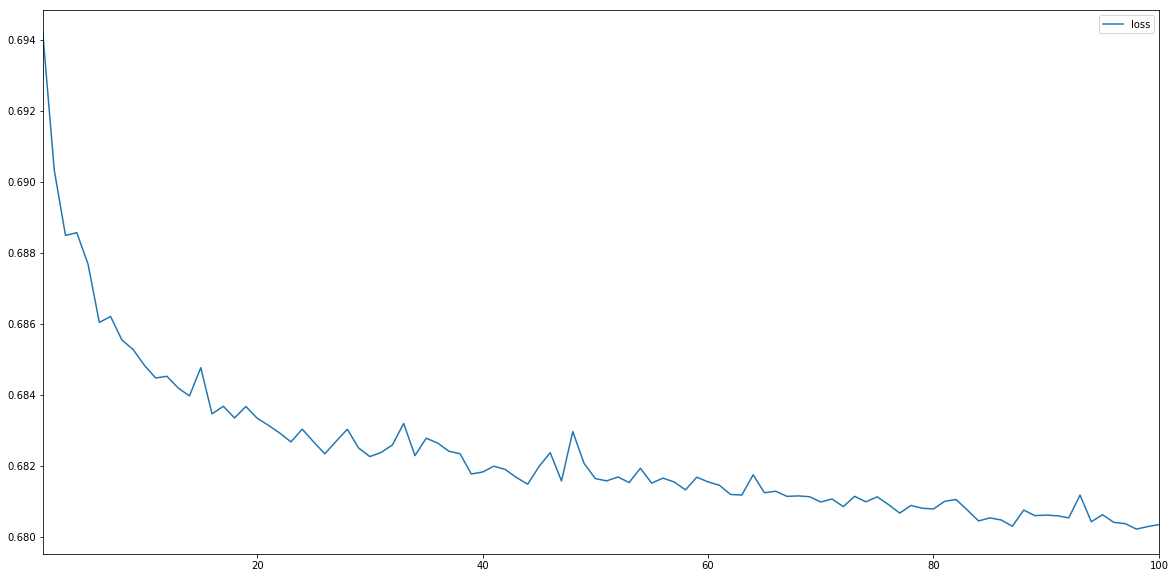

In [79]:
# Create a dataframe with the history dictionary
import matplotlib.pyplot as plt
df_plot = pd.DataFrame(model.history, index=range(1, len(model.history["loss"]) + 1))

# Plot the loss
df_plot.plot(y="loss",figsize=(20,10))
#plt.ylim(0,.7)

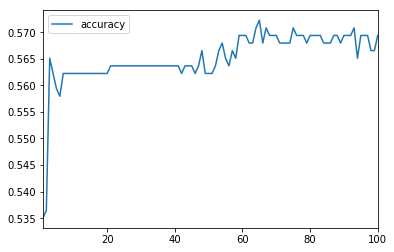

In [80]:
# Plot the accuracy
df_plot.plot(y="accuracy")
#plt.ylim(0,.7)

In [81]:
# Evaluate the model fit with linear dummy data
model_loss, model_accuracy = nn.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}") 

10/10 - 0s - loss: 0.6828 - accuracy: 0.5867
Loss: 0.6827781796455383, Accuracy: 0.5866666436195374


In [82]:
#track predictions
predicted = nn.predict(X_test)

## EVALUATE PERFORMANCE

In [83]:
results_nn = pd.DataFrame({'Actual': y_test,
                           'Close':df['close'][split:],
              'Predicted':predicted.ravel()
             })

#predicted results were showing a number between 0 and 1 so we force .5 or greater to be 1 otherwise 0
results_nn['Predicted'] = results_nn['Predicted'].apply(lambda x : 1 if x > .5 else 0)

#add returns to results
results_nn['Return'] = df['daily_return']

#for predicted loss then we set to -1 to create a short positioin
results_nn['Predicted'].replace(0, -1, inplace=True)

results_nn.head()

,Actual,Close,Predicted,Return
time,,,,
2019-12-31,1.0,321.89,1,0.002460
2020-01-02,1.0,324.84,1,0.009165
2020-01-03,0.0,322.44,1,-0.007388
2020-01-06,1.0,323.67,1,0.003815
2020-01-07,0.0,322.76,1,-0.002812


In [84]:
results_nn['Predicted'].value_counts()

 1    290
-1     10
Name: Predicted, dtype: int64

In [85]:
print(f"Algo Returns are:  {(1 + results_nn['Return'] * results_nn['Predicted']).cumprod()[-1]}")

Algo Returns are:  1.4308571162876786


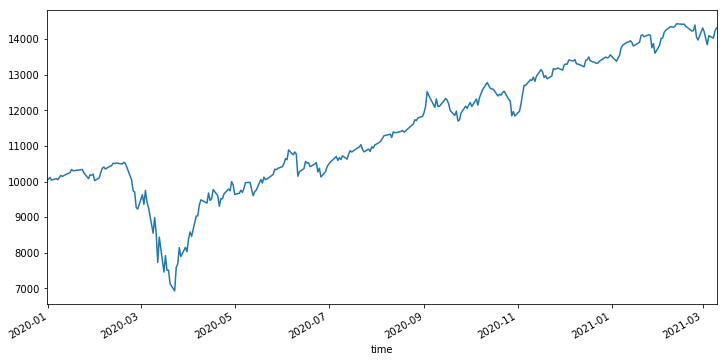

In [86]:
#calc with init cap of $10K
initial_capital = 10000
cumulative_return_capital_nn = initial_capital * (1 + (results_nn['Return'] * results_nn['Predicted'])).cumprod()
cumulative_return_capital_nn.plot(figsize=(12,6))
#cumulative_return_capital_nn.head()

In [87]:
import os
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from datetime import timedelta, date
from dateutil.relativedelta import relativedelta
load_dotenv()

alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object\n",
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

today = date.today()
start = today - timedelta(days=1460)
today = pd.Timestamp(today, tz="America/New_York").isoformat()
start = pd.Timestamp(start, tz="America/New_York").isoformat()

print(f"Today = {today} and Start = {start}")

# Set the tickers\n",
tickers = ["SPY"]

#timeframe
timeframe = "1D"

# Get current price data for MSFT and AAPL
df_sp500 = alpaca.get_barset(
    tickers,
    timeframe,
    start = start,
    end = today,
    limit=1000
).df

# Display data
df_sp500.columns = df_sp500.columns.get_level_values(1)
df_sp500.reset_index(inplace=True)
#df_sp500.head()

Today = 2021-03-10T00:00:00-05:00 and Start = 2017-03-11T00:00:00-05:00


In [88]:
#reset index
df_sp500['time'] = df_sp500['time'].dt.date
df_sp500.set_index('time',inplace=True)
df_sp500.index = pd.to_datetime(df_sp500.index)
df_sp500.index.dtype

dtype('<M8[ns]')

In [89]:
#df['daily_return_algo'] = df['close'].dropna().pct_change()

In [90]:
cumulative_ret = cumulative_return_capital_nn.to_frame()
cumulative_ret.index.dtype
#cumulative_ret.rename(columns={'Close':'algo_close'},inplace=True)
cumulative_ret.head()

,0
time,
2019-12-31,10024.602927
2020-01-02,10116.474618
2020-01-03,10041.731548
2020-01-06,10080.037372
2020-01-07,10051.697291


In [91]:
# cumulative_ret.reset_index(inplace=True)
# cumulative_ret['time'] = cumulative_ret.dt.date
# cumulative_ret.set_index('time', inplace=True)
# cumulative_ret.head()

In [92]:
df_sp500.head()

,open,high,low,close,volume
time,,,,,
2017-03-21,237.47,237.61,233.58,233.78,102898817
2017-03-22,233.77,234.61,233.05,234.27,70252351
2017-03-23,233.99,235.34,233.60,234.01,76534784
2017-03-24,234.38,235.04,232.96,233.90,82201507
2017-03-27,231.93,233.92,231.61,233.58,67180329


In [93]:
cumulative_ret.head()

,0
time,
2019-12-31,10024.602927
2020-01-02,10116.474618
2020-01-03,10041.731548
2020-01-06,10080.037372
2020-01-07,10051.697291


In [94]:
#concat dfs
together = pd.concat([df_sp500,cumulative_ret],axis=1)
together.tail()

,open,high,low,close,volume,0
time,,,,,,
2021-03-04,381.22,384.00,371.8800,376.7300,168203161,13838.748711
2021-03-05,380.46,384.76,372.6400,383.5950,133661539,14090.926690
2021-03-08,384.66,387.68,381.4200,381.7400,107185328,14022.785372
2021-03-09,385.85,389.91,381.7299,387.1100,97898909,14220.046223
2021-03-10,389.69,391.40,388.1702,389.5199,101349197,14308.571163


In [95]:
#settings
pd.set_option('display.max_rows', None)
together.head()

,open,high,low,close,volume,0
time,,,,,,
2017-03-21,237.47,237.61,233.58,233.78,102898817,NaN
2017-03-22,233.77,234.61,233.05,234.27,70252351,NaN
2017-03-23,233.99,235.34,233.60,234.01,76534784,NaN
2017-03-24,234.38,235.04,232.96,233.90,82201507,NaN
2017-03-27,231.93,233.92,231.61,233.58,67180329,NaN


In [96]:
together['market_daily_return'] = together['close'].dropna().pct_change()
#together.head()
#together = together[1:]
#together = together.drop(columns)

In [97]:
print(f"{cumulative_return_capital_nn.index[0]}")

2019-12-31 00:00:00


In [98]:
#together = together.loc['2020-11-16':]
#together

In [99]:
#together = together.loc['2020-11-16':]

together = together.loc[cumulative_return_capital_nn.index[0]:]
together.dropna(inplace=True)
together.head()

,open,high,low,close,volume,0,market_daily_return
time,,,,,,,
2019-12-31,320.53,322.13,320.15,321.89,38134256,10024.602927,0.002460
2020-01-02,323.54,324.85,322.53,324.84,48217559,10116.474618,0.009165
2020-01-03,321.16,323.64,321.10,322.44,58408809,10041.731548,-0.007388
2020-01-06,320.49,323.73,320.36,323.67,43105385,10080.037372,0.003815
2020-01-07,323.02,323.54,322.24,322.76,33909984,10051.697291,-0.002812


In [100]:
together['SP500'] = (1 + together['market_daily_return']).cumprod() * 10000
together = together.rename(columns = {0:"Algo"})
together.head()

,open,high,low,close,volume,Algo,market_daily_return,SP500
time,,,,,,,,
2019-12-31,320.53,322.13,320.15,321.89,38134256,10024.602927,0.002460,10024.602927
2020-01-02,323.54,324.85,322.53,324.84,48217559,10116.474618,0.009165,10116.474618
2020-01-03,321.16,323.64,321.10,322.44,58408809,10041.731548,-0.007388,10041.731548
2020-01-06,320.49,323.73,320.36,323.67,43105385,10080.037372,0.003815,10080.037372
2020-01-07,323.02,323.54,322.24,322.76,33909984,10051.697291,-0.002812,10051.697291


In [101]:
#results_nn.loc['2020-10-01':'2020-11-01']

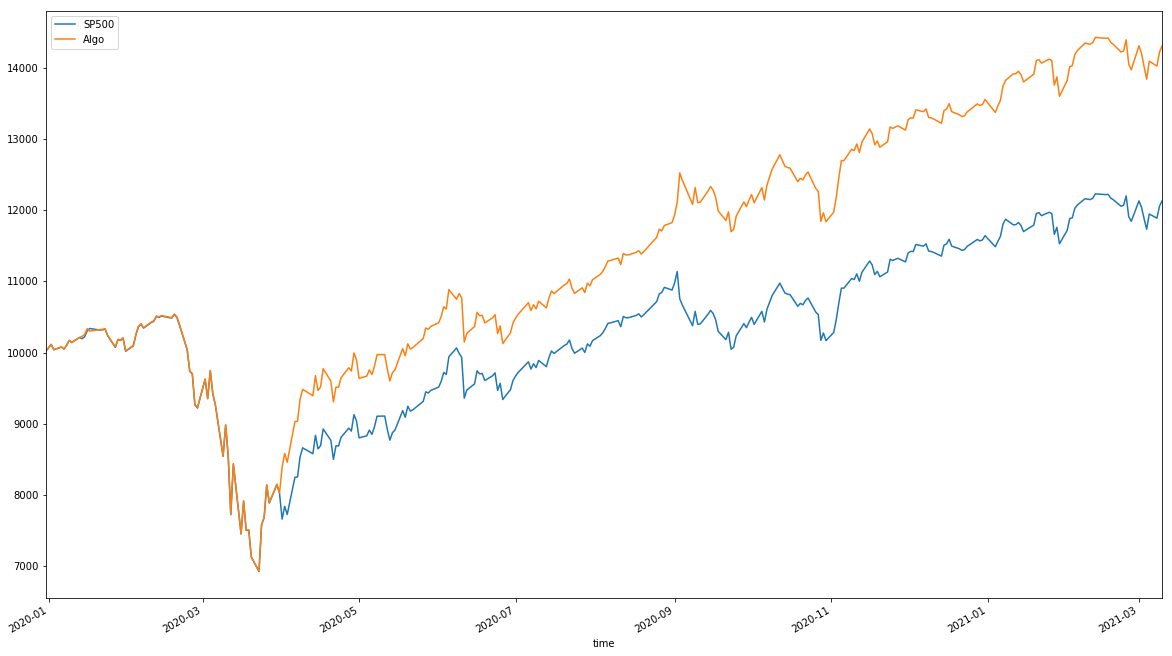

In [102]:
together[["SP500","Algo"]].plot(figsize=(20,12))